In [7]:
# Install required packages
!pip install numpyro
!pip install pandas
!pip install --upgrade xlrd
!pip install funsor

# Import necessary libraries
from google.colab import drive
import pandas as pd
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from sklearn.metrics import r2_score
from scipy import stats

# Mount Google Drive to the Colab environment
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import jax.numpy as jnp
from numpyro.distributions.transforms import AffineTransform

# Define custom distribution for ZeroOrNormal
class ZeroOrNormal(dist.Distribution):
    support = dist.constraints.real

    def __init__(self, mu, sigma, v):
        self.mu = mu
        self.sigma = sigma
        self.v = v
        super().__init__(batch_shape=(), event_shape=(1,))

    def sample(self, key, sample_shape=()):
        if self.v == 1:
            return numpyro.sample("normal", dist.Normal(jnp.full(sample_shape, self.mu), jnp.full(sample_shape, self.sigma)))
        else:
            return jnp.zeros(sample_shape)

    def log_prob(self, value):
        normal_lp = dist.Normal(jnp.full(value.shape, self.mu), jnp.full(value.shape, self.sigma)).log_prob(value)
        zero_lp = jnp.log(self.v == 0)
        return jnp.where(value == 0, zero_lp, normal_lp)

# Define the logistic function
def logistic(X, alpha, beta):
    tmp = -alpha * (X - beta)
    return 1 / (1 + math.e**(tmp))

In [3]:
# Define the trustgame model
def trustgame(z_a, z_t, m=None, p=None):
    w_a = numpyro.sample('w_a', dist.Normal(0, 1))
    w_t = numpyro.sample('w_t', dist.Normal(0, 1))
    w_0 = numpyro.sample('w_0', dist.Normal(0, 1))
    alpha_r = numpyro.sample('alpha_r', dist.Gamma(5))
    beta_r = numpyro.sample('beta_r', dist.Normal(1, 1))
    sigma_r = numpyro.sample('sigma_r', dist.HalfNormal(0.5))
    a = numpyro.sample('a', dist.Normal(100, 100))
    b = numpyro.sample('b', dist.Normal(100, 100))
    sigma_m = numpyro.sample('sigma_m', dist.HalfNormal(100))
    r = numpyro.sample('r', dist.Normal(w_a * z_a + w_t * z_t+w_0, sigma_r))
    x = logistic(r, alpha_r, beta_r)

    p = numpyro.sample('p', dist.Bernoulli(x), obs=p)
    m_dist = ZeroOrNormal((a * r + b), sigma_m, p)
    m = numpyro.sample("m", m_dist, obs=m)

In [4]:
# Define the trustgamecv function for cross-validation
def trustgamecv(attractive,trustworthy,w_a,w_t,w0,sigma_r,alpha,beta,a,b,sigma_m):
    r = np.random.normal(attractive*w_a+trustworthy*w_t+w0, sigma_r, 1)
    x = logistic(r, alpha, beta)
    p = np.random.binomial(1, x)
    if p == 1:
        return np.random.normal(a*r+b,sigma_m,1)
    else:
        return 0


In [5]:
# Load data from the Excel file
df_hc = pd.read_excel('/content/drive/MyDrive/hikikomoridata/HC.xls',sheet_name="Sheet31")

# Extract data from the dataframe
z_a_hc = df_hc['attractive'].head(30).values
z_t_hc = df_hc['trust'].head(30).values
m_hc = df_hc['money'].head(30).values
p_hc = df_hc['pay'].head(30).values
z_a_test = df_hc['attractive'].tail(10).values
z_t_test = df_hc['trust'].tail(10).values
m_test = df_hc['money'].tail(10).values
p_test = df_hc['pay'].tail(10).values

In [8]:
# Initialize the NUTS sampler and MCMC method
nuts_kernel = NUTS(trustgame, adapt_step_size=True)
mcmc_cv = MCMC(nuts_kernel, num_warmup=1000, num_samples=3000)
rng_key = random.PRNGKey(3407)

# Run the MCMC method on the data
mcmc_cv.run(rng_key, z_a_hc, z_t_hc, p=p_hc, m=m_hc)

# Print the summary of the MCMC results
mcmc_cv.print_summary()

sample: 100%|██████████| 4000/4000 [00:25<00:00, 155.62it/s, 127 steps of size 4.02e-02. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     66.47     23.76     62.51     30.68     98.95    162.95      1.00
   alpha_r      5.15      2.13      4.84      1.82      8.16   1160.86      1.00
         b     41.96     49.62     43.43    -42.19    121.43    411.14      1.00
    beta_r      0.67      0.70      0.65     -0.51      1.82    327.48      1.00
      r[0]     -0.20      0.87     -0.16     -1.66      1.17    415.45      1.00
      r[1]      4.46      1.65      4.28      1.64      7.02    174.54      1.00
      r[2]      4.66      1.68      4.48      1.66      7.09    171.20      1.00
      r[3]      3.47      1.29      3.34      1.19      5.39    186.53      1.00
      r[4]      5.22      1.77      5.04      2.30      8.06    162.90      1.00
      r[5]      6.78      2.20      6.60      3.33     10.41    155.36      1.00
      r[6]      8.33      2.69      8.05      3.75     12.46    147.66      1.00
      r[7]      4.55      1

In [9]:
# Extract posterior samples from the MCMC results
posterior_samples = mcmc_cv.get_samples()
w_a_cv = np.mean(posterior_samples["w_a"])
w_t_cv = np.mean(posterior_samples["w_t"])
w_0_cv = np.mean(posterior_samples["w_0"])
alpha_cv = np.mean(posterior_samples["alpha_r"])
beta_cv = np.mean(posterior_samples["beta_r"])
sigma_r_cv = np.mean(posterior_samples["sigma_r"])
a_cv = np.mean(posterior_samples["a"])
b_cv = np.mean(posterior_samples["b"])
sigma_m_cv = np.mean(posterior_samples["sigma_m"])


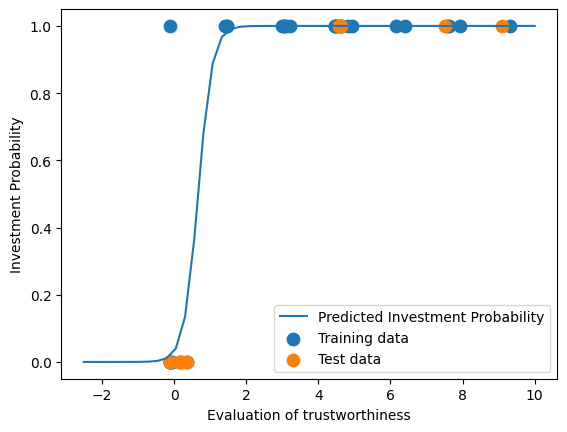

In [10]:
# Define the range for the evaluation of trustworthiness
r = np.linspace(-2.5,10)

# Calculate the predicted investment probability using the logistic function
p = logistic(r, alpha_cv, beta_cv)

# Calculate the evaluation of trustworthiness for test and training data
r_cv = z_a_test*w_a_cv + z_t_test*w_t_cv + w_0_cv
r_train = z_a_hc*w_a_cv + z_t_hc*w_t_cv + w_0_cv

# Plot the predicted investment probability against the evaluation of trustworthiness
plt.plot(r, p, label="Predicted Investment Probability")
plt.scatter(r_train, p_hc, label="Training data", color='#1f77b4', s=80)
plt.scatter(r_cv, p_test, label="Test data", color='#ff7f0e', s=80)
plt.xlabel('Evaluation of trustworthiness')
plt.ylabel('Investment Probability')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

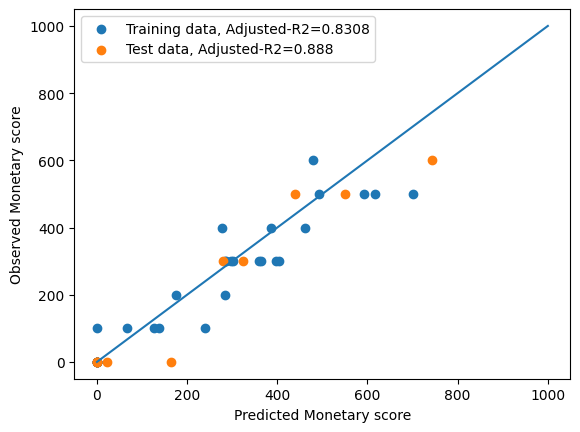

In [11]:
# Define the range for the monetary score
u = np.linspace(0, 1000)
e = u
plt.plot(e, u)

# Calculate the predicted monetary score for training and test data using the trustgamecv function
z_test = [trustgamecv(z_a_test[j], z_t_test[j], w_a_cv, w_t_cv, w_0_cv, sigma_r_cv, alpha_cv, beta_cv, a_cv, b_cv, sigma_m_cv) for j in range(10)]
z_train = [trustgamecv(z_a_hc[i], z_t_hc[i], w_a_cv, w_t_cv, w_0_cv, sigma_r_cv, alpha_cv, beta_cv, a_cv, b_cv, sigma_m_cv) for i in range(30)]

# Calculate the adjusted R-squared values for test and training data
r21 = r2_score(m_test, z_test)
r2_test_adj = 1 - ((1 - r21) * (len(m_test) - 1) / (len(m_test) - 2))
r22 = r2_score(m_hc, z_train)
r2_train_adj = 1 - ((1 - r22) * (len(m_hc) - 1) / (len(m_hc) - 2))

# Plot the predicted monetary score against the observed monetary score
plt.scatter(z_train, m_hc, label=f"Training data, Adjusted-R2={round(r2_train_adj, 4)}", color='#1f77b4')
plt.scatter(z_test, m_test, label=f"Test data, Adjusted-R2={round(r2_test_adj, 4)}", color='#ff7f0e')
plt.xlabel('Predicted Monetary score')
plt.ylabel('Observed Monetary score')
plt.legend()
plt.show()